In [1]:
!pip install torchscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchscan import summary

import matplotlib.pyplot as plt
import seaborn as sns

import tqdm
from tqdm.notebook import tqdm as tqdm_nb

import warnings
warnings.filterwarnings("ignore")

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 2, 3, padding=1, stride=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 64, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
ae = AutoEncoder()
summary(ae, (1, 28, 28))
del ae

__________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #        
autoencoder                  AutoEncoder           (-1, 1, 28, 28)           0              
├─encoder                    Sequential            (-1, 2, 7, 7)             0              
|    └─0                     Conv2d                (-1, 32, 28, 28)          320            
|    └─1                     ReLU                  (-1, 32, 28, 28)          0              
|    └─2                     Conv2d                (-1, 64, 14, 14)          18,496         
|    └─3                     ReLU                  (-1, 64, 14, 14)          0              
|    └─4                     Conv2d                (-1, 64, 7, 7)            36,928         
|    └─5                     ReLU                  (-1, 64, 7, 7)            0              
|    └─6                     Conv2d                (-1, 2, 7, 7)        

In [5]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (1.0,))
])

In [6]:
from torchvision.datasets import MNIST

download_root = './MNIST'

train_dataset = MNIST(download_root, transform=transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=transform, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [7]:
from torch.utils.data import DataLoader

bs = 64  # batch size

train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
valid_loader = DataLoader(dataset=test_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=bs, shuffle=True)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [32]:
from mpl_toolkits.axes_grid1 import ImageGrid

def imgrid(array, rows, cols):
    plt.axis('off')
    plt.gcf().set_size_inches(cols, rows)
    grid = ImageGrid(plt.gcf(), 111, (rows, cols), axes_pad=0.1)
    for ax in grid: ax.axis("off")
    for ax, im in zip(grid, array):
        ax.axis('off')
        ax.imshow(im)
    return grid


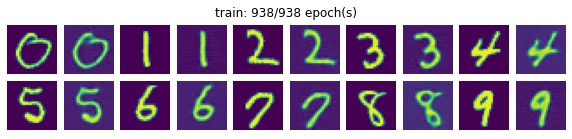

In [71]:
import io
import imageio
import numpy as np
from PIL import Image
from torchvision.transforms.transforms import Lambda
from IPython.display import clear_output
from time import sleep

model = AutoEncoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

keyframes = []
losses = []
kf_wait = 0

model.train()
total = len(train_loader)
for idx, (inputs, outputs) in tqdm_nb(enumerate(train_loader), total=total):
    inputs = inputs.to(device)
    y_hat = model(inputs).to(device)
    loss = criterion(y_hat, inputs)
    losses.append(loss.detach().cpu().item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if idx < 30:
        is_record = np.random.randint(1, 10) <= 4
    else:
        kf_wait += 1
        is_record = kf_wait > 9 and idx % 10 == np.random.randint(1, 10)
    if is_record or idx + 1 == total:
        kf_wait = 0
        lab = {}
        for (i, l) in enumerate(outputs):
            label = l.item()
            if not label in lab:
                lab[label] = i
            if len(lab) >= 10:
                break
        if len(lab) != 10: continue
        images = torch.empty((1, 28, 28)).to(device)
        for label, i in sorted(lab.items()):
            images = torch.row_stack([images, inputs[i].view(-1, 28, 28)])
            images = torch.row_stack([images, y_hat[i].view(-1, 28, 28)])
        images = images[1:].detach().cpu().numpy()
        plt.title(f'train: {idx + 1}/{total} epoch(s)')
        imgrid(images, 2, 10)
        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='png')
        keyframes.append(np.array(plt.gcf().canvas.renderer._renderer))
        img_buf.close()
        plt.show()
        clear_output(wait=True)

imageio.mimsave('./mnist.gif', keyframes)

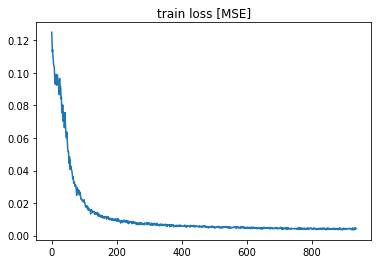

In [72]:
plt.title('train loss [MSE]')
sns.lineplot(x=range(len(losses)), y=losses)

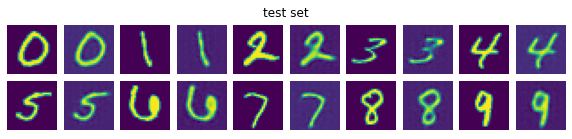

In [34]:
keyframes = []

model.eval()
total = len(test_loader)
for idx, (inputs, outputs) in tqdm_nb(enumerate(test_loader), total=total):
    inputs = inputs.to(device)
    y_hat = model(inputs).to(device)

    if idx % 10 == 0:
        lab = {}
        for (i, l) in enumerate(outputs):
            label = l.item()
            if not label in lab:
                lab[label] = i
            if len(lab) >= 10:
                break
        if len(lab) != 10: continue
        images = torch.empty((1, 28, 28)).to(device)
        for label, i in sorted(lab.items()):
            images = torch.row_stack([images, inputs[i].view(-1, 28, 28)])
            images = torch.row_stack([images, y_hat[i].view(-1, 28, 28)])
        images = images[1:].detach().cpu().numpy()
        plt.title(f'test set')
        imgrid(images, 2, 10)
        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='png')
        keyframes.append(np.array(plt.gcf().canvas.renderer._renderer))
        img_buf.close()
        plt.show()
        clear_output(wait=True)

imageio.mimsave('./mnist_test.gif', keyframes)